In [ ]:
# Step 1 — File upload / load (Colab upload বা local path থেকে লোড)
import pandas as pd
try:
    # Option A: Colab upload (comment out if not needed)
    from google.colab import files
    uploaded = files.upload()
    import io
    fname = list(uploaded.keys())[0]
    df = pd.read_csv(io.BytesIO(uploaded[fname]))
    print("Loaded uploaded file:", fname)
except Exception:
    # Option B: use existing path (your uploaded file path)
    FILEPATH = "/mnt/data/diabetes prediction.csv"
    df = pd.read_csv(FILEPATH)
    print("Loaded file from path:", FILEPATH)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Saving diabetes prediction.csv to diabetes prediction.csv
Loaded uploaded file: diabetes prediction.csv
Shape: (768, 9)
Columns: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'Gender']


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Gender
0,148,72,35,0,33.6,0.627,50,1,Male
1,85,66,29,0,26.6,0.351,31,0,Female
2,183,64,0,0,23.3,0.672,32,1,Male
3,89,66,23,94,28.1,0.167,21,0,Male
4,137,40,35,168,43.1,2.288,33,1,Male


In [ ]:
# Step 2 — Quick EDA (info, describe, nulls, 0-check)
print(df.info())
print("\nDescribe:\n", df.describe())
print("\nMissing per column:\n", df.isnull().sum())

zero_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for c in zero_cols:
    if c in df.columns:
        print(f"{c} zeros:", (df[c] == 0).sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Glucose                   768 non-null    int64  
 1   BloodPressure             768 non-null    int64  
 2   SkinThickness             768 non-null    int64  
 3   Insulin                   768 non-null    int64  
 4   BMI                       768 non-null    float64
 5   DiabetesPedigreeFunction  768 non-null    float64
 6   Age                       768 non-null    int64  
 7   Outcome                   768 non-null    int64  
 8   Gender                    768 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 54.1+ KB
None

Describe:
           Glucose  BloodPressure  SkinThickness     Insulin         BMI  \
count  768.000000     768.000000     768.000000  768.000000  768.000000   
mean   120.894531      69.105469      20.536458   79.799479  

In [ ]:
# Step 3 — Preprocessing (Gender encoding, 0->NaN, detect target, split)
import numpy as np
from sklearn.model_selection import train_test_split

# Gender encoding (safe)
if 'Gender' in df.columns:
    df['Gender'] = df['Gender'].astype(str).str.strip().str.lower()
    df['Gender'] = df['Gender'].replace({'male':1, 'm':1, 'female':0, 'f':0})
    # any remaining non-numeric map to NaN
    df.loc[~df['Gender'].isin([0,1]), 'Gender'] = np.nan
    print("Gender unique values after encode:", df['Gender'].unique())

# detect target column (common names) and fallback to last col
possible_targets = ['Outcome','target','Target','Class','diabetes','Diabetes']
target_col = None
for t in possible_targets:
    if t in df.columns:
        target_col = t
        break
if target_col is None:
    target_col = df.columns[-1]
print("Target column detected:", target_col)

# Replace Pima-style zeros -> NaN for selected numeric columns
zero_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()
for c in zero_cols:
    if c in X.columns:
        X.loc[X[c] == 0, c] = np.nan

# Train-test split (stratify if possible)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
    stratify=y if len(pd.Series(y).unique())>1 else None
)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)


Gender unique values after encode: [1. 0.]
Target column detected: Outcome
X_train shape: (614, 8) X_test shape: (154, 8)


/tmp/ipython-input-3495906650.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].replace({'male':1, 'm':1, 'female':0, 'f':0})


In [ ]:
# Step 4 — Preprocessing pipeline (median impute + StandardScaler) এবং সেভ করা
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import joblib

preproc = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),   # median imputation
    ('scaler', StandardScaler())                      # Standard scaling
])

X_train_prep = preproc.fit_transform(X_train)
X_test_prep  = preproc.transform(X_test)

print("Preprocessing done. X_train_prep shape:", X_train_prep.shape)
joblib.dump(preproc, 'preprocessing_pipeline.joblib')
print("Saved preprocessing pipeline -> preprocessing_pipeline.joblib")


Preprocessing done. X_train_prep shape: (614, 8)
Saved preprocessing pipeline -> preprocessing_pipeline.joblib


In [ ]:
# Step 5 — Feature Engineering
import numpy as np

feat_df = df.copy()
# examples: BMI*Age, Glucose/BMI ratio (safe division)
if 'BMI' in feat_df.columns and 'Age' in feat_df.columns:
    feat_df['BMI_Age'] = feat_df['BMI'] * feat_df['Age']
if 'Glucose' in feat_df.columns and 'BMI' in feat_df.columns:
    feat_df['Glucose_BMI_ratio'] = feat_df['Glucose'] / feat_df['BMI'].replace(0, np.nan)

print("Added features (if applicable):", [c for c in feat_df.columns if c not in df.columns])

# Re-prepare X,y and re-split & re-preprocess to include new features
X = feat_df.drop(columns=[target_col]).copy()
y = feat_df[target_col].copy()
for c in zero_cols:
    if c in X.columns:
        X.loc[X[c] == 0, c] = np.nan

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if len(pd.Series(y).unique())>1 else None
)

# re-fit preprocessing pipeline (so new features included)
X_train_prep = preproc.fit_transform(X_train)
X_test_prep  = preproc.transform(X_test)
print("Feature engineering applied and preprocessing re-fit.")
print("X_train_prep shape:", X_train_prep.shape)


Added features (if applicable): ['BMI_Age', 'Glucose_BMI_ratio']
Feature engineering applied and preprocessing re-fit.
X_train_prep shape: (614, 10)


In [ ]:
# Step 6 — Logistic Regression (Train & Save)
from sklearn.linear_model import LogisticRegression
import joblib

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_prep, y_train)
print("Logistic Regression trained.")
joblib.dump({'preproc': preproc, 'model': log_clf}, 'logistic_pipeline.joblib')
print("Saved -> logistic_pipeline.joblib")


Logistic Regression trained.
Saved -> logistic_pipeline.joblib


In [ ]:
# Step 7 — Random Forest (Train & Save)
from sklearn.ensemble import RandomForestClassifier
import joblib

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_prep, y_train)
print("Random Forest trained.")
joblib.dump({'preproc': preproc, 'model': rf_clf}, 'rf_pipeline.joblib')
print("Saved -> rf_pipeline.joblib")


Random Forest trained.
Saved -> rf_pipeline.joblib


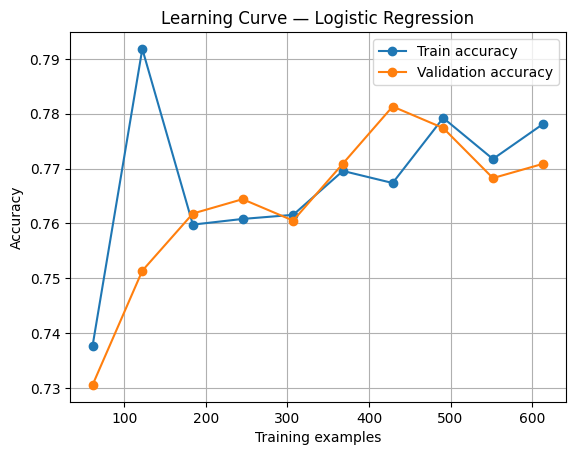

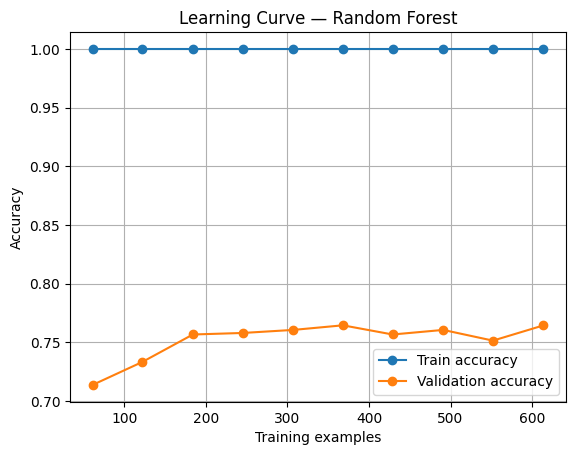

In [ ]:
# Step 8 — Training & Validation Accuracy Curve (Learning Curve)
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# prepare full preprocessed X (fit preproc on full feature set)
X_full_prep = preproc.transform(X) if hasattr(preproc, 'transform') else preproc.fit_transform(X)

def plot_learning_curve(estimator, Xp, yp, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, Xp, yp, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1,1.0,10), n_jobs=-1
    )
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)
    plt.figure()
    plt.plot(train_sizes, train_mean, 'o-', label='Train accuracy')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation accuracy')
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curve(LogisticRegression(max_iter=1000), X_full_prep, y, 'Learning Curve — Logistic Regression')
plot_learning_curve(RandomForestClassifier(n_estimators=100), X_full_prep, y, 'Learning Curve — Random Forest')


In [ ]:
# Step 9 — Precision, Recall, F1 (print for both models)
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred_log = log_clf.predict(X_test_prep)
y_pred_rf  = rf_clf.predict(X_test_prep)

print("Logistic Regression -> Precision:", round(precision_score(y_test, y_pred_log, zero_division=0),4),
      "Recall:", round(recall_score(y_test, y_pred_log, zero_division=0),4),
      "F1:", round(f1_score(y_test, y_pred_log, zero_division=0),4))

print("Random Forest -> Precision:", round(precision_score(y_test, y_pred_rf, zero_division=0),4),
      "Recall:", round(recall_score(y_test, y_pred_rf, zero_division=0),4),
      "F1:", round(f1_score(y_test, y_pred_rf, zero_division=0),4))


Logistic Regression -> Precision: 0.6222 Recall: 0.5185 F1: 0.5657
Random Forest -> Precision: 0.6136 Recall: 0.5 F1: 0.551


Logistic ROC-AUC: 0.79
RF ROC-AUC: 0.7986


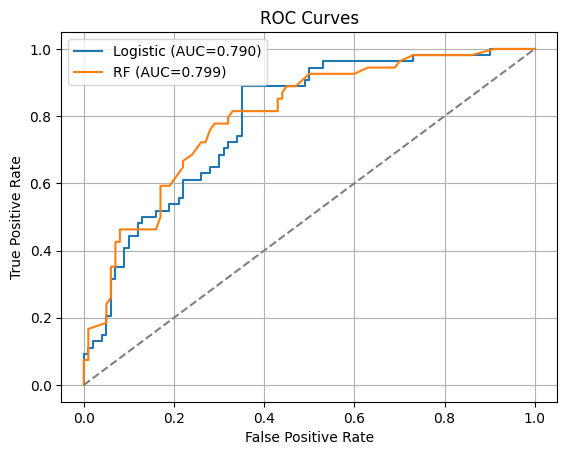

In [ ]:
# Step 10 — ROC–AUC (compute and plot ROC curves for both)
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

plt.figure()
# Logistic
try:
    y_proba_log = log_clf.predict_proba(X_test_prep)[:,1]
    auc_log = roc_auc_score(y_test, y_proba_log)
    fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
    plt.plot(fpr_log, tpr_log, label=f'Logistic (AUC={auc_log:.3f})')
    print("Logistic ROC-AUC:", round(auc_log,4))
except Exception as e:
    print("Logistic ROC error:", e)

# Random Forest
try:
    y_proba_rf = rf_clf.predict_proba(X_test_prep)[:,1]
    auc_rf = roc_auc_score(y_test, y_proba_rf)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
    plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC={auc_rf:.3f})')
    print("RF ROC-AUC:", round(auc_rf,4))
except Exception as e:
    print("RF ROC error:", e)

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()


Logistic Confusion Matrix:
 [[83 17]
 [26 28]]


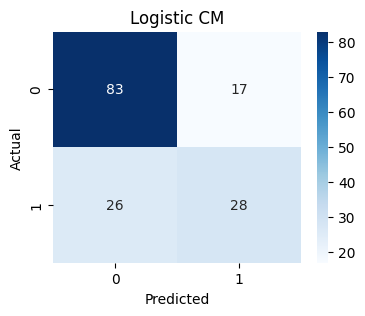

Logistic Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.83      0.79       100
           1       0.62      0.52      0.57        54

    accuracy                           0.72       154
   macro avg       0.69      0.67      0.68       154
weighted avg       0.71      0.72      0.71       154

RF Confusion Matrix:
 [[83 17]
 [27 27]]


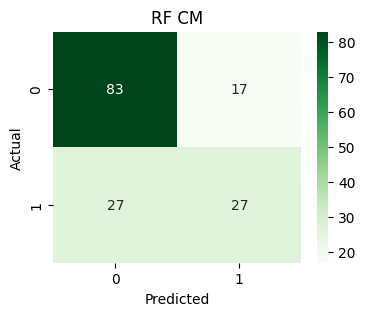

RF Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79       100
           1       0.61      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154



In [ ]:
# Step 11 — Confusion Matrix (print + heatmap) এবং Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Logistic
cm_log = confusion_matrix(y_test, y_pred_log)
print("Logistic Confusion Matrix:\n", cm_log)
plt.figure(figsize=(4,3)); sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues'); plt.title('Logistic CM'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()
print("Logistic Classification Report:\n", classification_report(y_test, y_pred_log))

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("RF Confusion Matrix:\n", cm_rf)
plt.figure(figsize=(4,3)); sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens'); plt.title('RF CM'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()
print("RF Classification Report:\n", classification_report(y_test, y_pred_rf))

In [ ]:
# Step 12 — Test Accuracy summary & final save (Final results)
from sklearn.metrics import accuracy_score
import joblib

acc_log = accuracy_score(y_test, y_pred_log)
acc_rf  = accuracy_score(y_test, y_pred_rf)
print("Final Test Accuracy -> Logistic:", round(acc_log,4))
print("Final Test Accuracy -> Random Forest:", round(acc_rf,4))

# Save final pipelines & models (optional)
joblib.dump({'preproc': preproc, 'model': log_clf}, 'logistic_pipeline_final.joblib')
joblib.dump({'preproc': preproc, 'model': rf_clf}, 'rf_pipeline_final.joblib')
print("Saved final pipelines: logistic_pipeline_final.joblib, rf_pipeline_final.joblib")

Final Test Accuracy -> Logistic: 0.7208
Final Test Accuracy -> Random Forest: 0.7143
Saved final pipelines: logistic_pipeline_final.joblib, rf_pipeline_final.joblib
